In [1]:
#Author: ML Tlachac
#Paper: Symptom Detection with Text Message Log Distributions for Holistic Depression and Anxiety Screening
#year: 2024
#github.com/mltlachac/SLOTH

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import nltk

from datetime import datetime, timedelta
from dateutil import parser
from datetime import timezone

In [2]:
df = pd.read_csv("textd2.csv")
df = df.drop_duplicates().reset_index(drop = True)
print(df.shape)

(280397, 4)


In [3]:
print(len(set(df.id)))
test = df[df.Direction == 2]
print(len(set(test.id)))

134
65


In [4]:
scoredf = pd.read_csv("surveysd2.csv")
scoredf = scoredf.drop_duplicates().reset_index(drop = True)
tdf = pd.read_csv("timed2.csv").drop_duplicates().reset_index(drop = True)

ilist = []
plist = []
glist = []
for i in set(scoredf["id"]):
    tempdfp = scoredf[(scoredf["id"] == i) & (scoredf["tool"] == 'phq')].reset_index(drop = True)
    tempdfg = scoredf[(scoredf["id"] == i) & (scoredf["tool"] == 'gad')].reset_index(drop = True)
    p = 0
    g = 0
    for s in range(0,9):
        p += int(tempdfp['Q'+ str(s)][0])
    for s in range(0,7):
        g += int(tempdfg['Q'+ str(s)][0])
    plist.append(p)
    glist.append(g)
    ilist.append(i)

scoredf2 = pd.DataFrame()
scoredf2["id"] = ilist
scoredf2['PHQ - Total'] = plist
scoredf2['GAD - Total'] = glist
print(scoredf2.shape)
scoredf = scoredf2.merge(tdf, on = ["id"]).dropna().reset_index()
print(scoredf.shape)
scoredf.head()

(181, 3)
(173, 5)


,index,id,PHQ - Total,GAD - Total,Timestamp
0,0,VRXMHQ8PT,23,17,8/24/2021 20:47
1,1,EDDVAOURK,0,0,8/3/2021 0:19
2,2,SC0IAEKNH,2,1,8/2/2021 20:43
3,3,HXGIVUFQY,1,0,8/3/2021 13:50
4,4,WLJ6QRMTD,6,1,7/31/2021 11:13


In [5]:
sorted(scoredf.Timestamp)

['10/10/2021 8:20',
 '10/11/2021 20:39',
 '10/11/2021 20:56',
 '10/11/2021 23:46',
 '10/12/2021 11:20',
 '10/17/2021 0:32',
 '10/18/2021 20:39',
 '10/18/2021 20:54',
 '10/2/2021 20:28',
 '10/6/2021 5:11',
 '10/6/2021 8:20',
 '10/9/2021 18:00',
 '10/9/2021 3:37',
 '10/9/2021 3:43',
 '7/13/2021 18:03',
 '7/15/2021 19:06',
 '7/15/2021 19:15',
 '7/16/2021 15:45',
 '7/19/2021 0:05',
 '7/26/2021 13:36',
 '7/26/2021 13:54',
 '7/26/2021 14:03',
 '7/26/2021 14:05',
 '7/26/2021 14:33',
 '7/26/2021 14:35',
 '7/26/2021 14:46',
 '7/26/2021 14:58',
 '7/26/2021 15:29',
 '7/26/2021 15:58',
 '7/26/2021 16:19',
 '7/26/2021 16:33',
 '7/26/2021 17:04',
 '7/26/2021 17:48',
 '7/26/2021 21:14',
 '7/26/2021 21:20',
 '7/26/2021 23:36',
 '7/26/2021 23:49',
 '7/27/2021 11:22',
 '7/27/2021 1:48',
 '7/27/2021 6:31',
 '7/31/2021 11:13',
 '7/5/2021 16:13',
 '7/5/2021 19:05',
 '7/5/2021 23:37',
 '7/7/2021 18:53',
 '7/9/2021 11:02',
 '8/13/2021 0:01',
 '8/13/2021 16:41',
 '8/14/2021 19:34',
 '8/15/2021 12:14',
 '8/15/

In [6]:
def unixTS(p):
    sdf = scoredf[scoredf["id"] == p].reset_index()
    s = str(sdf["Timestamp"][0])
    #print(s)
    phq = int(sdf['PHQ - Total'][0])
    gad = int(sdf['GAD - Total'][0])
    
    year = int(s[-10:-5].strip("/ "))
    month = int(s[0:1])
    day = int(s[2:4].strip("/"))
    hour = int(s[-5:-3].strip(" "))
    minute = int(s[-2:])

    dt = datetime(year,month,day,hour,minute)
    ts = dt.replace(tzinfo=timezone.utc).timestamp()
    ts = datetime.fromtimestamp(ts)
    return(ts,phq,gad)

#value = unixTS(p)

In [7]:
ndays = 14

print("Number of participants: " + str(len(set(df["id"]))))

participant = []
#single values
conversations = [] #number of contacts with 1s and 2s
exchanges = [] #number of 2 after 1
totalreplies = [] #number of outgoing messages in convos
totalrec = [] #number of incoming messages in convos

#list of values
latencylist = [] #time between 2 and 1
ratiolist = [] #ratio of 2 to 1
replylist = [] #number of 2s between 1s
reclist = [] #number of 1s between 2s

phqlist = []
gadlist = []


for p in set(scoredf["id"]):
    print(p)
    #limit to participant p
    
    dfp = df[df["id"] == p]
    dfp = dfp.sort_values(by=["UnixTimestamp"])
    
    #get window of ndays
    timeEnd,phq,gad = unixTS(p)
    #print(timeEnd)
    #print(phq)
    #print(gad)
    timeStart = timeEnd - timedelta(days=ndays)
    ts = int(timeStart.replace(tzinfo=timezone.utc).timestamp()*1000)
    
    #limit data to ndays
    dfp = dfp[dfp["UnixTimestamp"]>ts]
    dfin = dfp[dfp["Direction"] == 1].shape[0]
    dfout = dfp[dfp["Direction"] == 2].shape[0]
    
    latencies = []
    ccount = 0 #count of conversations
    ratios = []
    replies = []
    rec = []
    nReply = 0 
    nIn = 0
    ecount = 0 #count of 2 to 1
    
    
    #limit to contact c
    for c in set(dfp["Contact"]):
        dfc = dfp[dfp["Contact"] == c]
        #check if incoming and outgoing messages
        if len(set(dfc["Direction"])) == 2:
            cin = dfc[dfc["Direction"] == 1].shape[0]
            cout = dfc[dfc["Direction"] == 2].shape[0]
            ratios.append(cout/(cin+cout))
            ccount = ccount + 1 #n conversations increase by 1
            nReply += cout #total number of outgoing messages
            nIn += cin
            directions = list(dfc["Direction"])
            times = list(dfc["UnixTimestamp"])
            rcount = 0
            dcount = 0
            
            #calculate latencies
            for i in range(1, len(directions)):
                if (directions[i] == 2) & (directions[i-1] == 1):
                    first = datetime.fromtimestamp(int(times[i-1])/1000)
                    second = datetime.fromtimestamp(int(times[i])/1000)
                    diff = (second-first).seconds
                    latencies.append(diff)
                    ecount += 1
            
            
            #calculate messages before response for 2s
            for i in range(0, len(directions)):
                if (directions[i] == 2):
                    rcount += 1
                    if i == (len(directions)-1):
                        replies.append(rcount)
                elif (directions[i] == 1):
                    if rcount > 0:
                        replies.append(rcount)
                    rcount = 0
                    
            #calculate messages before response for 1s
            for i in range(0, len(directions)):
                if (directions[i] == 1):
                    dcount += 1
                    if i == (len(directions)-1):
                        rec.append(dcount)
                elif (directions[i] == 2):
                    if dcount > 0:
                        rec.append(dcount)
                    dcount = 0
                
    
    #fill in lists for df
    participant.append(p)
    phqlist.append(phq)
    gadlist.append(gad)
    
    conversations.append(ccount) #count of contacts
    exchanges.append(ecount) #count of 2 after 1
    totalreplies.append(nReply) #total number of 2
    totalrec.append(nIn) #total number of 1
    
    latencylist.append(latencies)
    replylist.append(replies)
    reclist.append(rec) 
    ratiolist.append(ratios)

Number of participants: 134
VRXMHQ8PT
EDDVAOURK
SC0IAEKNH
HXGIVUFQY
WLJ6QRMTD
M6ESVACH0
LBQ02VNZE
WUNGNAEN2
SEKOYTQRZ
VO2V6ULJD
4QC32WOTE
UHNP5WMZQ
TQXDAPWVW
WPOBXMWW4
RKBJ0D0YJ
C55SA4M36
8CTSQ3PY6
RL1AU4JGE
SY4QRL3H6
O21DGINOW
1MP1HOPN1
LT7IG2QEH
HOBTX83LM
WEWV3OMTJ
SMSWUG2N0
9Q8RPTTMK
U40JO4D74
16C77CO54
XNWRY81J4
0PDU1ZGAK
4RZ2L66W5
ODS7Y967E
WWP1A6MFH
AG7FIUDGD
5AUD3W85Z
LPSE6HPX6
76AKK82OL
F30Q75WMS
46WRV46K5
U75WBHZ5H
OQFDRZ06E
1OXCSWTWX
85I8NJD3J
ZRA53CBDN
S30NA32MX
5CJWJT9VU
GKO9459UJ
MNNY3N154
QYFNLN498
Q0NRWRH9Y
U1OKHWME8
I0XE4VB6X
2BIE56NEB
S7N01L6XO
PPXYN5DYL
6VGODYFHP
DE8QDHE65
EGFC7E3YF
K0S77OWON
VV8KG5I91
TP68UWTK3
FFDRW448G
N8HR1UNJI
PJ40X1KIF
ZI626UTVD
0HGEFMWB1
VG35UMYU6
69IOR5L65
UPGBDGRBD
UZDHPWIUK
AUV3X2010
ENXWKMQJY
Z6KUG6OHY
K49X8B3H0
N32CZLRJV
AKLOXLMDE
XI7WCUSSL
D2PZNGS5G
5BSDKIC38
9LBTI544S
QOAQ0ILA8
E96GAMWH2
9ARGVDQXM
6KR8PM9CT
WXT65Y8P3
QH5CNSXI6
VAL2ILNGS
F1BWLBQBL
UDT5KDMWJ
84BQ9MF7O
476KH3VDR
P1G24NWAV
AEJBUZ0OS
DSWGIYEP9
7RNVLGD60
K476I20I5
ZFWM9YHC9
QA

In [8]:
#create df with latencies
newdf = pd.DataFrame()
newdf['id'] = participant
newdf["phq"] = phqlist
newdf["gad"] = gadlist

newdf['conversations'] = conversations
newdf['exchanges'] = exchanges
newdf['sent'] = totalreplies

newdf['outgoing'] = replylist
newdf['latencyContact'] = latencylist
newdf['ratio'] = ratiolist

### Intrepretation
* conversations = len(ratio)
* exchanges = len(latencyContact)
* sent = sum(outgoing)

In [9]:
print(newdf.shape[0])
newdf = newdf[newdf.exchanges >= 7]
print(newdf.shape[0])

173
31


In [10]:
#newdf.to_csv("distributionsSLOTH.csv")

[0, 0, 0, 0, 1, 2, 3, 4, 5, 5, 6, 7, 8, 8, 10, 11, 11, 12, 12, 12, 13, 14, 14, 15, 17, 17, 20, 22, 22, 27, 27]


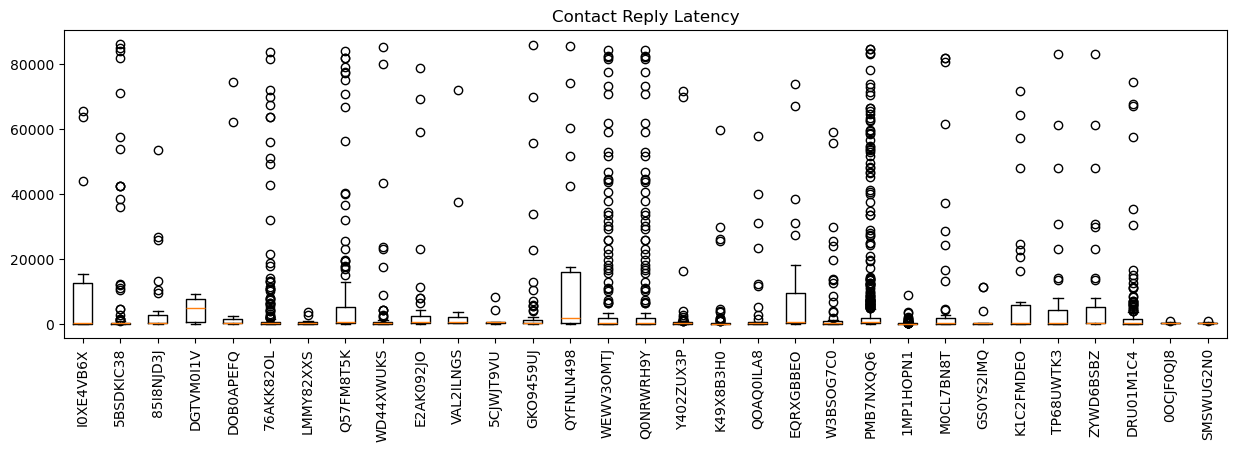

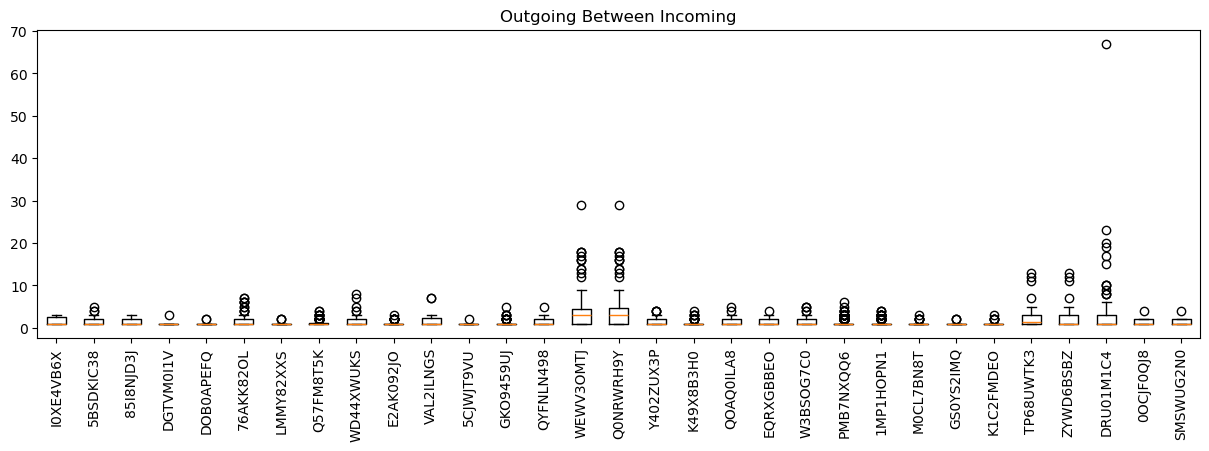

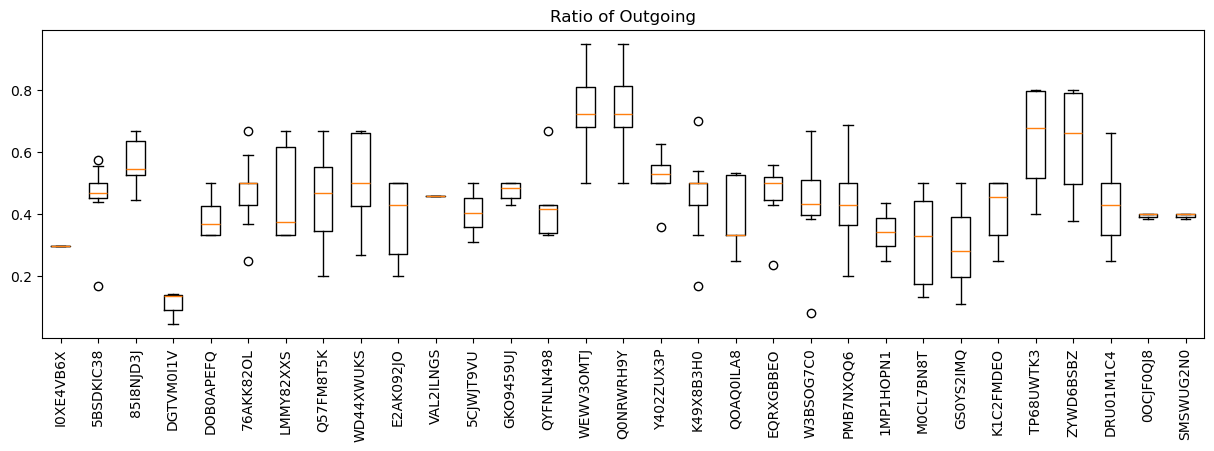

In [11]:
newdf = newdf.sort_values(by = "phq")
print(list(newdf.phq))
import matplotlib.pyplot as plt

plt.figure(figsize = (15,4))
plt.title("Contact Reply Latency")
plt.boxplot(newdf.latencyContact)
plt.xticks(list(range(1,newdf.shape[0]+1)), list(newdf["id"]), rotation = 'vertical')
plt.show()
plt.close()

plt.figure(figsize = (15,4))
plt.title("Outgoing Between Incoming")
plt.boxplot(newdf.outgoing)
plt.xticks(list(range(1,newdf.shape[0]+1)), list(newdf["id"]), rotation = 'vertical')
plt.show()
plt.close()

plt.figure(figsize = (15,4))
plt.title("Ratio of Outgoing")
plt.boxplot(newdf.ratio)
plt.xticks(list(range(1,newdf.shape[0]+1)), list(newdf["id"]), rotation = 'vertical')
plt.show()
plt.close()

In [12]:
#extract latency features
newdf = newdf.reset_index(drop=True)

minlist = []
whisker0 = []
quant10 = []
quant25 = []
quant50 = []
quant75 = []
quant90 = []
whisker1 = []
maxlist = []
outliers = []

for i in range(0, newdf.shape[0]):    
    upper_quantile = np.quantile(newdf.latencyContact[i], 0.75)
    lower_quantile = np.quantile(newdf.latencyContact[i], 0.25)
    iqr = upper_quantile - lower_quantile
    upper_whisker = upper_quantile+1.5*iqr
    lower_whisker = lower_quantile-1.5*iqr
    upper_outliers = len(list(filter(lambda x: x > (upper_quantile+1.5*iqr), newdf.latencyContact[i])))
    lower_outliers = len(list(filter(lambda x: x < (lower_quantile-1.5*iqr), newdf.latencyContact[i])))
    if lower_whisker < 0:
        lower_whisker = 0
    
    minlist.append(min(newdf.latencyContact[i]))
    whisker0.append(lower_whisker)
    quant10.append(np.quantile(newdf.latencyContact[i], 0.1))
    quant25.append(np.quantile(newdf.latencyContact[i], 0.25))
    quant50.append(np.quantile(newdf.latencyContact[i], 0.5))
    quant75.append(np.quantile(newdf.latencyContact[i], 0.75))
    quant90.append(np.quantile(newdf.latencyContact[i], 0.9))
    whisker1.append(upper_whisker)
    maxlist.append(max(newdf.latencyContact[i]))
    outliers.append(upper_outliers + lower_outliers)
    
newdf['quant10_latencyC'] = quant10
newdf['quant25_latencyC'] = quant25
newdf['quant50_latencyC'] = quant50
newdf['quant75_latencyC'] = quant75
newdf['quant90_latencyC'] = quant90

minlist = []
whisker0 = []
quant10 = []
quant25 = []
quant50 = []
quant75 = []
quant90 = []
whisker1 = []
maxlist = []
outliers = []

for i in range(0, newdf.shape[0]):    
    upper_quantile = np.quantile(newdf.outgoing[i], 0.75)
    lower_quantile = np.quantile(newdf.outgoing[i], 0.25)
    iqr = upper_quantile - lower_quantile
    upper_whisker = upper_quantile+1.5*iqr
    lower_whisker = lower_quantile-1.5*iqr
    upper_outliers = len(list(filter(lambda x: x > (upper_quantile+1.5*iqr), newdf.outgoing[i])))
    lower_outliers = len(list(filter(lambda x: x < (lower_quantile-1.5*iqr), newdf.outgoing[i])))
    if lower_whisker < 1:
        lower_whisker = 1
    
    minlist.append(min(newdf.outgoing[i]))
    whisker0.append(lower_whisker)
    quant10.append(np.quantile(newdf.outgoing[i], 0.1))
    quant25.append(np.quantile(newdf.outgoing[i], 0.25))
    quant50.append(np.quantile(newdf.outgoing[i], 0.5))
    quant75.append(np.quantile(newdf.outgoing[i], 0.75))
    quant90.append(np.quantile(newdf.outgoing[i], 0.9))
    whisker1.append(upper_whisker)
    maxlist.append(max(newdf.outgoing[i]))
    outliers.append(upper_outliers + lower_outliers)
    
newdf['quant10_outgoing'] = quant10
newdf['quant25_outgoing'] = quant25
newdf['quant50_outgoing'] = quant50
newdf['quant75_outgoing'] = quant75
newdf['quant90_outgoing'] = quant90

minlist = []
whisker0 = []
quant10 = []
quant25 = []
quant50 = []
quant75 = []
quant90 = []
whisker1 = []
maxlist = []
outliers = []

for i in range(0, newdf.shape[0]):    
    upper_quantile = np.quantile(newdf.ratio[i], 0.75)
    lower_quantile = np.quantile(newdf.ratio[i], 0.25)
    iqr = upper_quantile - lower_quantile
    upper_whisker = upper_quantile+1.5*iqr
    lower_whisker = lower_quantile-1.5*iqr
    upper_outliers = len(list(filter(lambda x: x > (upper_quantile+1.5*iqr), newdf.ratio[i])))
    lower_outliers = len(list(filter(lambda x: x < (lower_quantile-1.5*iqr), newdf.ratio[i])))
    if lower_whisker < 0:
        lower_whisker = 0
    if upper_whisker < 1:
        upper_whisker = 1
    
    minlist.append(min(newdf.ratio[i]))
    whisker0.append(lower_whisker)
    quant10.append(np.quantile(newdf.ratio[i], 0.1))
    quant25.append(np.quantile(newdf.ratio[i], 0.25))
    quant50.append(np.quantile(newdf.ratio[i], 0.5))
    quant75.append(np.quantile(newdf.ratio[i], 0.75))
    quant90.append(np.quantile(newdf.ratio[i], 0.9))
    whisker1.append(upper_whisker)
    maxlist.append(max(newdf.ratio[i]))
    outliers.append(upper_outliers + lower_outliers)
    
newdf['quant10_ratio'] = quant10
newdf['quant25_ratio'] = quant25
newdf['quant50_ratio'] = quant50
newdf['quant75_ratio'] = quant75
newdf['quant90_ratio'] = quant90

In [13]:
print(newdf.shape)
print(newdf.columns)

(31, 24)
Index(['id', 'phq', 'gad', 'conversations', 'exchanges', 'sent', 'outgoing',
       'latencyContact', 'ratio', 'quant10_latencyC', 'quant25_latencyC',
       'quant50_latencyC', 'quant75_latencyC', 'quant90_latencyC',
       'quant10_outgoing', 'quant25_outgoing', 'quant50_outgoing',
       'quant75_outgoing', 'quant90_outgoing', 'quant10_ratio',
       'quant25_ratio', 'quant50_ratio', 'quant75_ratio', 'quant90_ratio'],
      dtype='object')


In [14]:
newdf.drop(columns = ['conversations', 'exchanges', 'sent', 'outgoing','latencyContact', 'ratio'], inplace = True)
print(newdf.shape)
#newdf.to_csv("featuresSLOTH.csv", index = False)

(31, 18)
